In [ ]:
# Importing required librariess
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt



In [ ]:
datasets_list = tfds.list_builders()
print('food101' in datasets_list)

True


In [ ]:
(train_data,test_data), ds_info = tfds.load(name='food101',split=['train', 'validation'],
                                            shuffle_files=True, as_supervised=True,
                                            with_info=True)

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features['label'].names
class_names[:20]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla']

In [ ]:
# Taking one sample of the train data
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info of training sample
for image, label in train_one_sample:
  print(f"Image Shape: {image.shape}, Image Datatype: {image.dtype}")



Image Shape: (512, 384, 3), Image Datatype: <dtype: 'uint8'>


In [ ]:
# Look of the image tensor without scaling
image

<tf.Tensor: shape=(512, 384, 3), dtype=uint8, numpy=
array([[[152, 129,  77],
        [160, 137,  85],
        [160, 137,  85],
        ...,
        [ 26,  21,  18],
        [ 24,  19,  16],
        [ 21,  16,  13]],

       [[156, 133,  81],
        [158, 135,  83],
        [155, 132,  80],
        ...,
        [ 25,  20,  17],
        [ 23,  18,  15],
        [ 22,  17,  14]],

       [[164, 141,  87],
        [159, 136,  82],
        [147, 124,  70],
        ...,
        [ 23,  18,  15],
        [ 21,  17,  14],
        [ 20,  16,  13]],

       ...,

       [[  1,  49, 121],
        [  0,  47, 119],
        [  0,  48, 120],
        ...,
        [ 26,  14,  16],
        [ 26,  14,  16],
        [ 32,  20,  22]],

       [[  1,  49, 121],
        [  0,  47, 119],
        [  0,  48, 120],
        ...,
        [ 24,  14,  15],
        [ 30,  18,  18],
        [ 30,  18,  18]],

       [[  2,  50, 122],
        [  0,  48, 120],
        [  0,  48, 120],
        ...,
        [ 22,  12,  1

In [ ]:
# Mix and Min tensor values
tf.reduce_min(image), tf.reduce_max(image) # Range of the values 1 - 255 (max)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

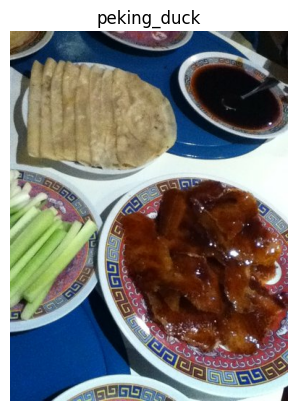

In [ ]:
# Image tensor plot
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

In [ ]:
# Function for preprocessing the images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32 and reshapes
  image.
  """
  image = tf.image.resize (image, [img_shape, img_shape])
  #image = image/255.
  return tf.cast(image, tf.float32), label


# Batch & Prepare the data


In [ ]:
# Map preprocessing functions to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffel train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
# Trun on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16') # setting global data policy to mixed precision

# Build Feature Extraction model

In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape = input_shape, name = 'input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
output = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy' based on your labels
    metrics=['accuracy']
)


In [ ]:
len(class_names)

101

In [ ]:
# Fit the model
history_model_1 = model.fit(train_data, epochs=3,
                            steps_per_epoch=len(train_data), validation_data = test_data,
                            validation_steps = int(0.15 * len(test_data)))

Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 202s 73ms/step - accuracy: 0.4783 - loss: 2.2854 - val_accuracy: 0.7002 - val_loss: 1.1322
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 165s 64ms/step - accuracy: 0.6661 - loss: 1.2920 - val_accuracy: 0.7158 - val_loss: 1.0285
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 204s 85ms/step - accuracy: 0.7049 - loss: 1.1288 - val_accuracy: 0.7238 - val_loss: 0.9965


The Validation Accuracy is 72.38 %

In [ ]:
# Evaluate the model
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step - accuracy: 0.7245 - loss: 1.0023


[0.9972954988479614, 0.7274455428123474]

Model Accuracy on test data 72.45 %